# NLP Analysis - "The Office" Dataset
This Notebook applies various common NLP-techniques to get a deep understanding of the conversations in the dataset.

In [23]:
import pandas as pd
import plotly.express as px
import plotly.subplots as subplots

import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.sentiment import SentimentIntensityAnalyzer
from collections import Counter
from collections import defaultdict

from yellowbrick.text import DispersionPlot

In [2]:
PATH = "../data/"
FILE = "the-office-lines - scripts.csv"

df = pd.read_csv(PATH+FILE, sep=",", index_col="id")
df.head()

,season,episode,scene,line_text,speaker,deleted
id,,,,,,
1,1,1,1,All right Jim. Your quarterlies look very good...,Michael,False
2,1,1,1,"Oh, I told you. I couldn't close it. So...",Jim,False
3,1,1,1,So you've come to the master for guidance? Is ...,Michael,False
4,1,1,1,"Actually, you called me in here, but yeah.",Jim,False
5,1,1,1,"All right. Well, let me show you how it's done.",Michael,False


In [4]:
# character appearance in scenes
char_app = df.sort_values(['season','episode','scene']).drop_duplicates(['season','episode','scene','speaker'],keep='first')
df_char_scene_episode = char_app.pivot_table(index='speaker', columns=['season','episode'], values='scene',aggfunc='count').dropna(axis=0, thresh=20)
df_char_scene_season = df_char_scene_episode.groupby(level=[0],axis=1).sum()

In [5]:
char_app_count = char_app.groupby(['speaker', 'season']).size().reset_index(name='counts')

char_app_count['season'] = char_app_count['season'].astype(str)

top_char = char_app.groupby(['speaker']).size().reset_index(name='counts').sort_values(by='counts', ascending=False)['speaker'].iloc[:20]

#filter for top 20 characters
char_app_count_sorted = char_app_count[char_app_count['speaker'].isin(top_char)]

fig = px.bar(char_app_count_sorted, x='speaker', y='counts', color='season', title='Scene appearances per character')
fig.update_xaxes(categoryorder='array', categoryarray= top_char)

In [11]:
char_wrd = df[['season', 'line_text', 'speaker']]

char_wrd['count_words'] = [len(x.split()) for x in df['line_text'].tolist()]
char_wrd['season'] = char_wrd['season'].astype(str)

char_wrd_count = char_wrd.groupby(['speaker', 'season'])['count_words'].agg('sum').reset_index()

top_wrd = char_wrd.groupby(['speaker'])['count_words'].agg('sum').sort_values(ascending=False).index[:20].to_list()

#filter for top 20 characters
char_wrd_filtered = char_wrd_count[char_wrd_count['speaker'].isin(top_wrd)]

fig = px.bar(char_wrd_filtered, x='speaker', y='count_words', color='season', title='Words per character')
fig.update_xaxes(categoryorder='array', categoryarray= top_wrd)

C:\Users\schla\AppData\Local\Temp\ipykernel_64388\15509826.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\schla\AppData\Local\Temp\ipykernel_64388\15509826.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [3]:
# Attention - i removed any non word characters here - they might be useful for further analysis
tokenizer = RegexpTokenizer(r'[\w\']+')
allWords = tokenizer.tokenize(' '.join(df['line_text'].tolist()))
allWordDist = nltk.FreqDist(w.lower() for w in allWords)

stopwords = nltk.corpus.stopwords.words('english')
allWordExceptStopDist = nltk.FreqDist(w.lower() for w in allWords if w not in stopwords) 


In [ ]:
df_allWordDist = pd.Series(dict(allWordDist)).sort_values(ascending=False)
df_allWordsExceptStopDist = pd.Series(dict(allWordExceptStopDist)).sort_values(ascending=False)

In [ ]:
fig1 = px.bar(y=df_allWordDist[:16].index, x=df_allWordDist[:16].values, orientation='h', title='Most common words')
fig2 = px.bar(y=df_allWordsExceptStopDist[:16].index, x=df_allWordsExceptStopDist[:16].values, orientation='h', title='Most commmon words (after stopword removal)')

fig1.show()
fig2.show()

c:\Users\schla\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3433: FutureWarning:

arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


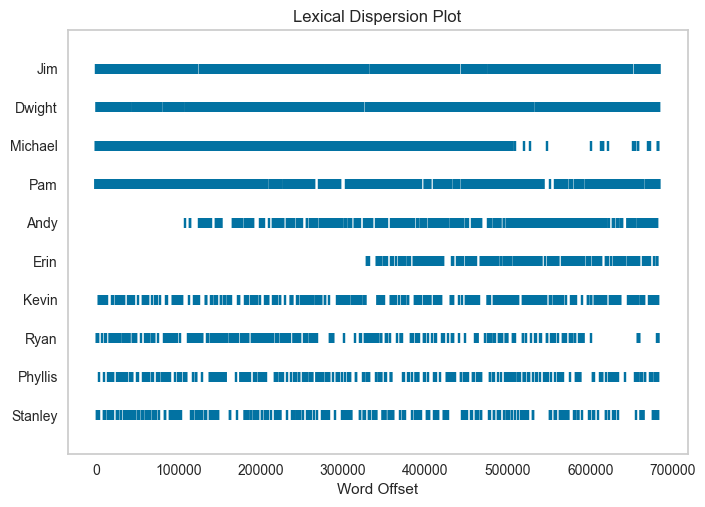

<AxesSubplot: title={'center': 'Lexical Dispersion Plot'}, xlabel='Word Offset'>

In [ ]:
# this analysis might also be done with other vocabs instead of person names

target_words = ['Jim', 'Dwight', 'Michael', 'Pam', 'Andy', 'Erin', 'Kevin', 'Ryan', 'Phyllis', 'Stanley']

visualizer = DispersionPlot(target_words)
visualizer.fit([allWords])
visualizer.show()

In [17]:
text = nltk.Text(allWords)
text.concordance('office', lines=5)

Displaying 5 of 1009 matches:
phone Yes I'd like to speak to your office manager please Yes hello This is Mi
n Levinson Gould walking out of his office Jan hello I call her Hillary Rodham
 this regime it will not leave this office zips his lips Like that So what doe
ee what people are like outside the office I think it could be fun It sounds g
ne time or another every guy in the office has sprayed on Pam What Messages Pe


In [21]:
#find n-grams
finder_2 = nltk.collocations.BigramCollocationFinder.from_words(allWords)
finder_3 = nltk.collocations.TrigramCollocationFinder.from_words(allWords)
finder_4 = nltk.collocations.QuadgramCollocationFinder.from_words(allWords)

finder_4.ngram_fd.most_common(5)

[(('I', 'want', 'you', 'to'), 161),
 (('What', 'are', 'you', 'doing'), 135),
 (('I', 'am', 'going', 'to'), 122),
 (('I', "don't", 'want', 'to'), 107),
 (('No', 'no', 'no', 'no'), 99)]

## Sentiment Analysis

In [28]:
sia = SentimentIntensityAnalyzer()
sia.polarity_scores("All right Jim. Your quarterlies look very good. How are things at the library?")

{'neg': 0.0, 'neu': 0.803, 'pos': 0.197, 'compound': 0.4927}

In [ ]:
#TODO: extract sentences as array from scene to get an idea if it is rather positive or negative.